In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from astropy.table import Table
from astropy import units as u
from astropy import coordinates as coords
# from astroquery.simbad import Simbad
import astroquery
plt.style.use("fivethirtyeight")

import gwb
import sys
sys.path.append("../")
import groupten

In [2]:
import tensorflow as tf
from edward.models import Normal, Uniform
import edward as ed

In [3]:
sess = tf.InteractiveSession()

In [4]:
ra = np.array([45., 45.5])
dec =np.array([30.2, 30.7])

# N, 2, 3
M_data = np.array(
    [[[-np.sin(rr), np.cos(rr), 0.],
     [-np.sin(dd)*np.cos(rr), -np.sin(dd)*np.sin(rr), np.cos(dd)]]
     for rr, dd in zip(np.deg2rad(ra), np.deg2rad(dec))])

v_true = np.array([50.3, -50.1, 22.6])
r_true = np.array([5.2, 10.2])
vtan_true = np.matmul(M_data,v_true)
x_true = np.concatenate(
    (1./r_true[:,None], vtan_true/r_true[:,None]), axis=1).reshape([3*2,])

fakecov = np.diag(np.abs(x_true)*0.08)

x_obs = np.random.multivariate_normal(x_true, fakecov**2)

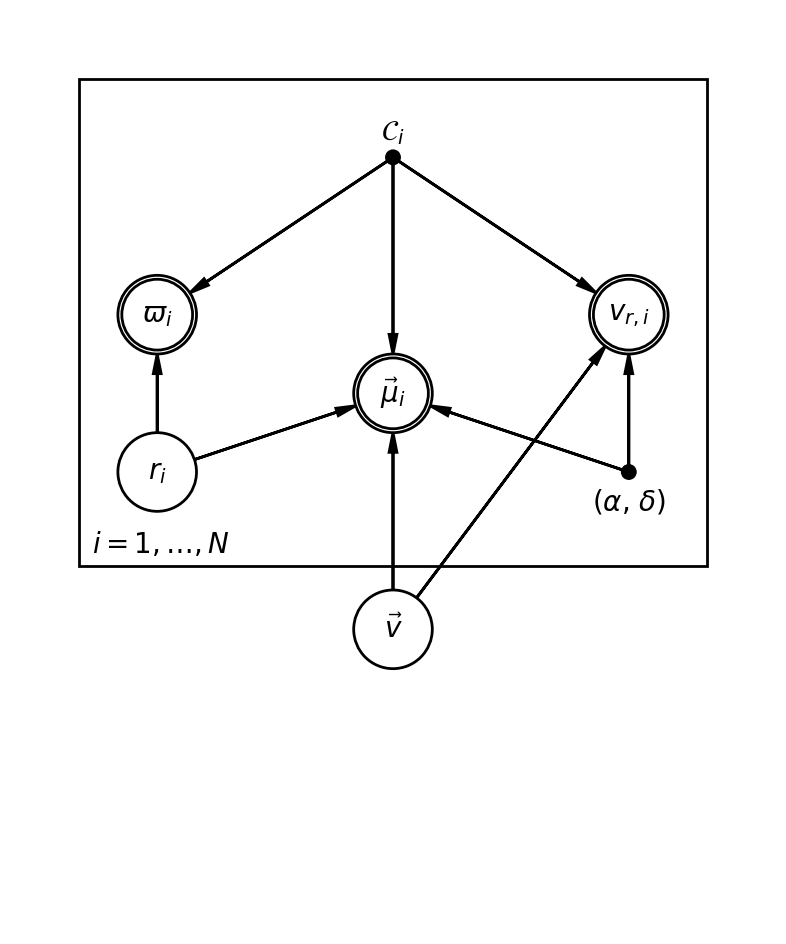

In [5]:
from IPython.display import Image
Image(filename='../../arv/pgm_samev.png', width=300)

In [5]:
N = 2  # number of stars
D = 3  # data dimension (parallax, pmra, pmdec)

# The observable `x` is 1d array of (parallax, pmra, pmdec) X N.
# Then, the covariance matrix `cov` should be block diagnoals
# of covariance matrix of indivisual objects -- not memeory efficient...

# x_hat = tf.placeholder(tf.float32, [D*N])    # p_i, pmra_i, pmdec_i
cov = tf.placeholder(tf.float32, [D*N,D*N])
M = tf.placeholder(tf.float32, [N, 2, 3])   # projection matrix

v = ed.models.MultivariateNormalFull(mu=tf.zeros(3), sigma=tf.eye(3)*50.**2)
# None of these priors are good, but just for tryout
# r = ed.models.Normal(mu=tf.ones(N)*40, sigma=50.)
r = ed.models.Uniform(a=tf.ones(N)*0.1, b=tf.ones(N)*20.)

V = tf.tile(tf.reshape(v, [1,3,1]), [N,1,1])
vtan = tf.reshape(tf.matmul(M, V), [N, 2])

p = tf.reshape(1./r, [-1,1])
xmu = tf.reshape(tf.concat([p, vtan*p], 1), [D*N])
x = ed.models.MultivariateNormalFull(mu=xmu, sigma=cov)

In [10]:
# variational inference -- not working
# qr = ed.models.Normal(mu=tf.Variable([5.,10.]), sigma=tf.nn.softplus(tf.Variable([2.,2.])))
# qv = ed.models.MultivariateNormalFull(mu=tf.Variable([25.3, 0.1, 22.6]),
#                                       sigma=tf.nn.softplus(tf.Variable(tf.eye(3)*2.)))

# data = {x: x_obs,
#         cov: fakecov**2,
#         M: M_data}
# inference = ed.KLqp({r:qr, v:qv}, data=data)
# inference.run()

In [6]:
# MC sampling
n_sample = 10000
qr = ed.models.Empirical(tf.Variable([list([5.,10.])]*n_sample))
qv = ed.models.Empirical(tf.Variable([list([0.,0.,0.])]*n_sample))

data = {x: x_obs,
        cov: fakecov**2,
        M: M_data}
inference = ed.HMC({r:qr, v:qv}, data)

# what's the right step size?
inference.run(step_size=.15)

10000/10000 [100%] ██████████████████████████████ Elapsed: 47s | Acceptance Rate: 0.963


In [7]:
qr.mean().eval(), qr.std().eval()

(array([ 5.08141851,  9.9172821 ], dtype=float32),
 array([ 0.36059782,  0.64897692], dtype=float32))

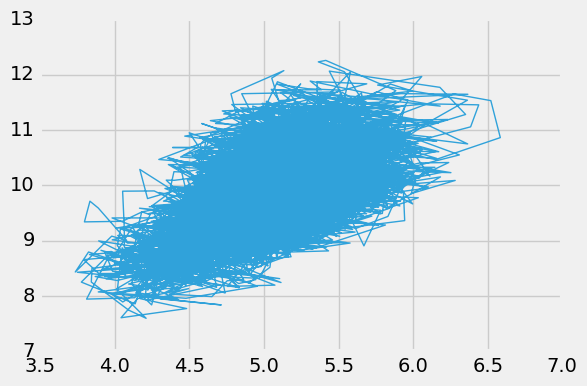

In [12]:
plt.plot(qr.params.eval()[:,0], qr.params.eval()[:,1], lw=1)
# plt.axvline(r_true[0]);
# plt.axhline(r_true[1]);
# plt.xsacle('log')

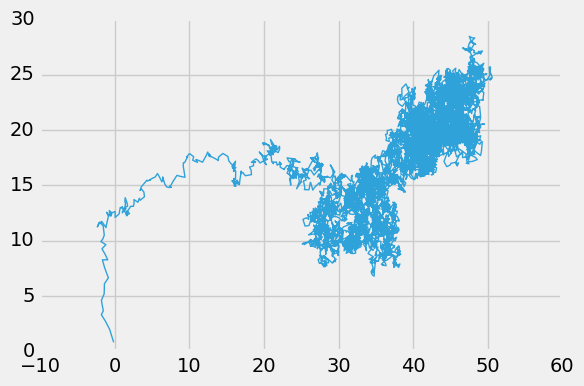

In [13]:
plt.plot(qv.params.eval()[:,0], qv.params.eval()[:,2], lw=1);

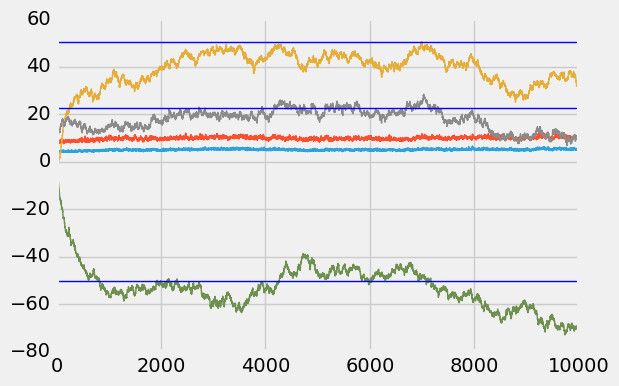

In [14]:
plt.plot(qr.params.eval()[:,0], lw=1);
plt.plot(qr.params.eval()[:,1], lw=1);
plt.plot(qv.params.eval()[:,0], lw=1);
plt.plot(qv.params.eval()[:,1], lw=1);
plt.plot(qv.params.eval()[:,2], lw=1);
for vv in v_true:
    plt.axhline(vv, lw=1);

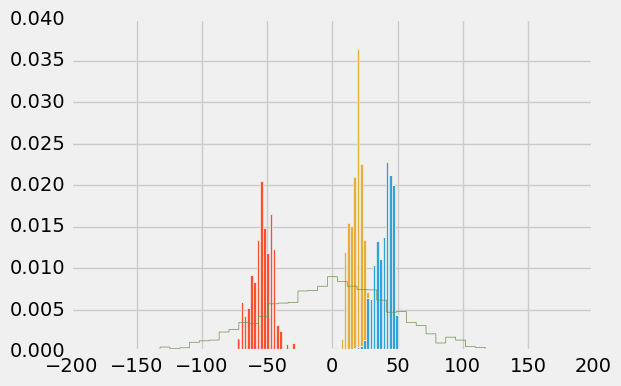

In [21]:
plt.hist(qv.params.eval(), stacked=True, bins=50, normed=True);
plt.hist(v.sample(3000).eval()[:,0], bins=50, histtype='step', normed=True);